# Описание исследования

Проводим работу с табличными данными, в которых представлена информация о стартапах, которые функционировали в период с 1980 по 2018 годы. Нужно предсказать, какие из них закроются, а какие нет. Соревнование проводится на популярной платформе Kaggle, что позволит не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой. 

# Цель исследования

- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

# Этапы исследования

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

# Описание данных

Датасет состоит из двух файлов: 
- тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). 
- Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. 
Временной период - '1970-01-01' по '2018-01-01'. 
Дата формирования выгрузки - '2018-01-01'

- `kaggle_startups_train_27042024.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- `kaggle_startups_test_27042024.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- `kaggle_startups_sample_submit_27042024.csv` - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed']. 

**Описание полей данных**
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий)
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

In [212]:
! pip install phik -q
! pip install shap -q
! pip install -U scikit-learn -q
! pip install seaborn --upgrade -q
! pip install missingno -q

In [213]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [236]:
import os
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

In [215]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", "{:.3f}".format)

In [216]:
def preprocessing(df):
    print('Изучение данных датафрейма "\n')
    print("Вывод первых 5 строк \n")
    display(df.head(5))
    print("-" * 100)
    print(f"Размерность датафрейма, составляет - {(df.shape)}")
    print("-" * 100)
    print("Общая информация:\n")
    display(df.info())
    print("-" * 100)
    print("Описательная статистика:\n")
    display(df.describe())
    print("-" * 100)
    df.isna().sum()
    print("Проверка на наличие явных дубликатов:\n")
    display(df.duplicated().sum())
    print("-" * 100)
    print("Вывод количества уникальных значений")
    display(pd.DataFrame(df.apply(lambda x: x.nunique())))

In [217]:
pth1 = "./datasets/kaggle_startups_train_27042024.csv"
pth2 = "./datasets/kaggle_startups_test_27042024.csv"

if os.path.exists(pth1):
    # Тренировочная выборка:
    df_ks_train = pd.read_csv(
        pth1,
        parse_dates=["founded_at", "first_funding_at", "last_funding_at", "closed_at"],
    )
    if os.path.exists(pth2):
        # Тестовая выборка:
        df_ks_test = pd.read_csv(pth2)
    else:
        print("Something is wrong")

Выведем первоначальную информацию о датафрейме с тренировочными данными

In [218]:
preprocessing(df_ks_train)

Изучение данных датафрейма "

Вывод первых 5 строк 



,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.000,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,NaT


----------------------------------------------------------------------------------------------------
Размерность датафрейма, составляет - (52514, 13)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  object        
 1   category_list      50049 non-null  object        
 2   funding_total_usd  42445 non-null  float64       
 3   status             52514 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     52514 non-null  int64         
 9   founded_at 

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,42445.000,52514.000,52514,52514,52514,4915
mean,18248255.980,1.741,2008-11-04 08:35:44.342460928,2011-07-17 04:55:32.779830016,2012-06-27 16:46:47.936931072,2012-01-17 17:10:42.360121856
min,1.000,1.000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-12-19 00:00:00
25%,336000.000,1.000,2006-09-28 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-10-01 12:00:00
50%,2000000.000,1.000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-10-01 00:00:00
75%,10000000.000,2.000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-30 12:00:00
max,30079503000.000,19.000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-11-12 00:00:00
std,187121675.710,1.375,NaN,NaN,NaN,NaN


----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



0

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений


,0
name,52513
category_list,22108
funding_total_usd,15551
status,2
country_code,134
state_code,300
region,1036
city,4477
funding_rounds,19
founded_at,5401


Посмотрим количество пропусков в тренировочных данных

In [219]:
nan_counts = df_ks_train.isna().sum()
print(nan_counts)

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64


In [220]:
# Создание объекта осей
fig, ax = plt.subplots(figsize=(18, 4))
# Генерация графика с использованием объекта осей
msno.matrix(df_ks_train, ax=ax, sparkline=False)
# Добавление названия графика
ax.set_title("Матрица пропущенных значений")
# Отображение графика
plt.show()

**Что можно сказать из первоначальных данных:**
- `name` - имеет 1 пропуск, думаю его можно оставить, так как данная колонка у нас отвечает за идентификаторы.
- `category_list`   - список категорий -  имеет большое количество пропусков, подумаем что с ними можно сделать  2465, так же иммет огромное количество категорий, но множество из них разделено знаком |, предлагаю удалить данные и оставить название категории до вышеуказанного символа. Позволит уменьшить количество уникальных категорий.
- `funding_total_usd`   - Общая сумма финансирования в USD - тоже множество пропусков  - 10069, предлагаю заполнить медианными значениями. 
- `status`   - статус. Не имеет проблем в данных
- `country_code`     - код старны - имеет много пропусков 5501, чем заполнить пока не ясно, оставим, так же имеет не так много категорий, переведем в категориальный тип.
- `state_code`      state_code - Код штата    имеет много пропусков  6762, чем заполнить пока не ясно, оставим, так же имеет не большое количество категорий, переведем в категориальный тип. 
- `region`        - региона, много пропусков -  6358, и много категорий. Думаю дальше данные эти не понадобятся для обучения модели, оставим пропуски
- `city`           - город, много пропусков -        6358, соответствует данным по региону. Вообще все пропуски связанные с географическим положением не заполнены в одинх и теж же строках, это можно наглядно увидеть по матрице пропусков. Возможно кто то заполнял только код страны, а остальные данные были не обязательны для заполнения, либо данные о них просто отсутствовали 
- `funding_rounds`  -   Количество раундов финансирования    - Не имеет проблем в данных. Только переведем в int, так как даные числовые.
- `founded_at`       -    Дата основания    - Не имеет проблем в данных.
- `first_funding_at`  -     Дата первого раунда финансирования - Не имеет проблем в данных.
- `last_funding_at`    -      Дата последнего раунда финансирования - Не имеет проблем в данных.
- `closed_at`        -    Дата закрытия стартапа (если применимо) - имеет большое количество пропусков - 47599, что может говорит о том, что большинство из представленных в данных стартапов являются действующими. Данная колонка будет мешать предсказанию, так как нам надо именно предсказать будет ли закрыт стартап или нет, поэтому заполним пропуски датой выгрузки данных и создадим новую синтетическую информацию, а именно `lifetime` - Время существования стартапа в днях, для этого посчитаем количество дней прошедших между датой основания и датой закрытия

Приведем типы данных

In [221]:
df_ks_train = df_ks_train.astype(
    {"funding_rounds": np.int32, "funding_total_usd": np.float32}
)
df_ks_train[df_ks_train.select_dtypes(["object"]).columns] = df_ks_train.select_dtypes(
    ["object"]
).apply(lambda x: x.astype("category"))
df_ks_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52514 entries, 0 to 52513
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52513 non-null  category      
 1   category_list      50049 non-null  category      
 2   funding_total_usd  42445 non-null  float32       
 3   status             52514 non-null  category      
 4   country_code       47013 non-null  category      
 5   state_code         45752 non-null  category      
 6   region             46156 non-null  category      
 7   city               46156 non-null  category      
 8   funding_rounds     52514 non-null  int32         
 9   founded_at         52514 non-null  datetime64[ns]
 10  first_funding_at   52514 non-null  datetime64[ns]
 11  last_funding_at    52514 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: category(7), datetime64[ns](4), float32(1), int32(1)
memor

Поработаем с колонкой category_list

In [222]:
df_ks_train["category_list"] = df_ks_train["category_list"].str.split("|").str[0]
df_ks_train["category_list"].nunique()

707

У нас существенно уменьшилось количество категорий к которым относятся стартапы с 22108 до 707

In [223]:
df_ks_train["funding_total_usd"].describe()

count         42445.000
mean       18248256.000
std       187121680.000
min               1.000
25%          336000.000
50%         2000000.000
75%        10000000.000
max     30079502336.000
Name: funding_total_usd, dtype: float64

Видим явный выброс, как значение 30 079 502 336, при том что медиана у нас всего 2 000 000 долларов, посмотрим на это значение и предлагаю удалить его.

In [224]:
df_ks_train.loc[df_ks_train["funding_total_usd"] == 30079502336]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
39183,Verizon Communications,Communications Infrastructure,30079502336.000,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,NaT


In [225]:
df_ks_train.drop(
    df_ks_train[df_ks_train["funding_total_usd"] == 30079502336].index, inplace=True
)

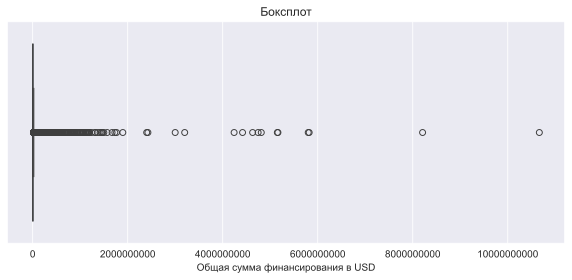

In [226]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x="funding_total_usd", data=df_ks_train, orient="h", ax=ax)
# Изменение формата меток на оси X
ax.ticklabel_format(style="plain", axis="x")
ax.set_title("Боксплот")
ax.set_xlabel("Общая сумма финансирования в USD")
plt.show()

In [227]:
df_ks_train.loc[df_ks_train["funding_total_usd"] > 2000000000]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4448,i-Cube,Application Platforms,4240250112.000,operating,USA,MA,Boston,Cambridge,3,1997-02-09,1998-02-01,1999-06-01,NaT
4557,Uber,Automotive,8207450112.000,operating,USA,CA,SF Bay Area,San Francisco,13,2009-03-01,2009-08-01,2015-09-07,NaT
5287,Cambridge Technology Partners (CTP),Architecture,5150000128.000,operating,NaN,NaN,NaN,NaN,2,1990-01-11,1995-01-01,2001-01-01,NaT
5515,COFCO,Agriculture,3200000000.000,operating,CHN,NaN,NaN,NaN,1,2012-08-16,2014-02-22,2014-02-22,NaT
9342,Suning,Distributors,4630000128.000,operating,CHN,4,Nanjing,Nanjing,1,1996-01-01,2015-08-10,2015-08-10,NaT
12184,Didi Kuaidi,Public Transportation,4417999872.000,operating,CHN,22,Beijing,Beijing,7,2012-09-01,2012-09-01,2015-09-07,NaT
15975,Clearwire,Internet,5820000256.000,operating,USA,WA,Seattle,Kirkland,6,2003-10-01,2001-12-11,2013-02-27,NaT
21239,Cambridge Technology Group,Consulting,10664943616.000,operating,NaN,NaN,NaN,NaN,1,1988-01-01,2000-01-01,2000-01-01,NaT
22104,Carestream,Biotechnology,2400000000.000,operating,USA,NY,"Rochester, New York",Rochester,1,2007-01-01,2013-06-12,2013-06-12,NaT
22482,Reliance Jio Infocomm Ltd.,Development Platforms,3000000000.000,operating,IND,16,Mumbai,Mumbai,3,2007-01-01,2014-09-25,2015-05-13,NaT


Больше 2 миллиардов долларов было вложено в 15 компаний, однако часть из них существует достаточно много лет и возможно действительно это достаточно успешний стартап и может иметь такое количество финансирования. Не будем пока удалять эти данные.
Заполним пропущенные данные медианой по группе категорий. Так как в category_list у нас есть пропуски, поставим заглушку заполнив данные пропуски значением 'Unknown'. Так как мы не знаем в какие категории могли попасть в эту группу, то заполним ее не медианой по группе 'Unknown', а глобальной медианой, для этого:
Создадим функцию fill_with_median которая проверяет, равна ли категория 'Unknown', и если это так, то она заполняет пропущенные значения в funding_total_usd глобальной медианой. Это гарантирует, что для категории 'Unknown' всегда будет использоваться глобальная медиана, а не медиана по группе 'Unknown'. Для остальных значений сначала проверяет есть ли в группе хоть 1 значение, если есть заполняет медианой по группе, в противном случае глобальной медианой.

In [228]:
# Заполнение пропущенных значений в столбце 'category_list' строкой 'Unknown'
df_ks_train["category_list"].fillna("Unknown", inplace=True)

# Вычисление глобальной медианы для столбца 'funding_total_usd'
global_median = df_ks_train["funding_total_usd"].median()


def fill_with_median(group, category):
    # Если категория группы - 'Unknown', заполнение NaN значений глобальной медианой
    if category == "Unknown":
        return group.fillna(global_median)
    # Проверка наличия хотя бы одного не-NaN значения в группе
    elif group.notna().any():
        # Заполнение NaN значений медианой группы
        return group.fillna(group.median())
    else:
        # Заполнение NaN значений глобальной медианой
        return group.fillna(global_median)


# Применение функции fill_with_median к каждой группе в столбце 'category_list'
df_ks_train["funding_total_usd"] = df_ks_train.groupby("category_list")[
    "funding_total_usd"
].transform(lambda x: fill_with_median(x, x.name))

In [229]:
df_ks_train.isna().sum()

name                     1
category_list            0
funding_total_usd        0
status                   0
country_code          5501
state_code            6762
region                6358
city                  6358
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47598
dtype: int64

Заполним closed_at датой выгрузки данных, для последующего создания столбца lifetime - Время существования стартапа в днях

In [232]:
df_ks_train["closed_at"] = df_ks_train["closed_at"].fillna(datetime(2018, 1, 1))

In [234]:
df_ks_train["lifetime"] = (df_ks_train["closed_at"] - df_ks_train["founded_at"]).dt.days
df_ks_train.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations,828626.000,operating,CHE,25,Zurich,Zürich,2,2009-12-31,2011-05-01,2014-12-01,2018-01-01,2923
1,EarLens,Manufacturing,42935020.000,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456380.000,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.000,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,3875000.000,operating,USA,VA,VA - Other,Bristol,1,2010-09-30,2012-02-01,2012-02-01,2018-01-01,2650


In [243]:
df_ks_train.drop(
    [
        "name",
        "region",
        "city",
        "founded_at",
        "first_funding_at",
        "last_funding_at",
        "closed_at",
    ],
    axis=1,
).phik_matrix(verbose=False)

,category_list,funding_total_usd,status,country_code,state_code,funding_rounds,lifetime
category_list,1.000,0.000,0.240,0.697,0.499,0.123,0.378
funding_total_usd,0.000,1.000,0.000,0.000,0.000,0.177,0.049
status,0.240,0.000,1.000,0.125,0.115,0.099,0.536
country_code,0.697,0.000,0.125,1.000,0.993,0.000,0.190
state_code,0.499,0.000,0.115,0.993,1.000,0.000,0.256
funding_rounds,0.123,0.177,0.099,0.000,0.000,1.000,0.250
lifetime,0.378,0.049,0.536,0.190,0.256,0.250,1.000


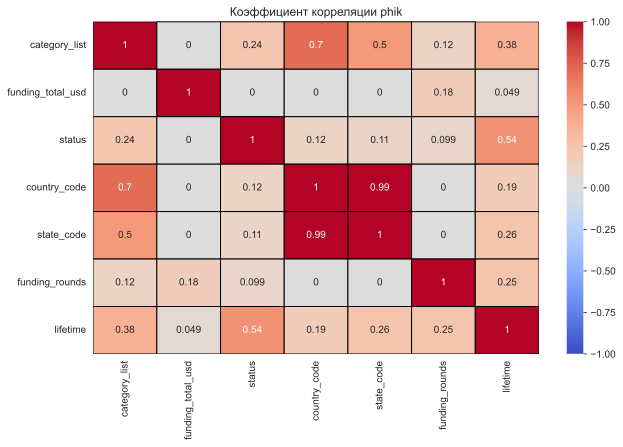

In [244]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    df_ks_train.drop(
        [
            "name",
            "region",
            "city",
            "founded_at",
            "first_funding_at",
            "last_funding_at",
            "closed_at",
        ],
        axis=1,
    ).phik_matrix(verbose=False),
    annot=True,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    linewidths=1,
    linecolor="black",
)
plt.title("Коэффициент корреляции phik")
plt.show()